### Step 1 - Imports

In [19]:
import os
from pathlib import Path
import random
import math
import time
import json
import zipfile
import warnings

import itertools, pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from tqdm.auto import tqdm

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from dataclasses import dataclass
from typing import Tuple, List, Dict, Optional

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


### Step 2 - Retrieve Data

In [9]:
tfm = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))])

train_full = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
test_set   = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

train_set, val_set = random_split(
    train_full, [50000, 10000],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=128)
test_loader  = DataLoader(test_set,  batch_size=128)

print(f"Train/Val/Test sizes: {len(train_set)}/{len(val_set)}/{len(test_set)}")

Train/Val/Test sizes: 50000/10000/10000


In [10]:
xb, yb = next(iter(train_loader))
print("Batch shapes:", xb.shape, yb.shape)           # expect [128, 1, 28, 28], [128]
print("Label sample:", yb[:16].tolist())
assert xb.shape[1:] == (1, 28, 28), "Unexpected image shape."

Batch shapes: torch.Size([128, 1, 28, 28]) torch.Size([128])
Label sample: [9, 2, 6, 8, 0, 5, 9, 2, 2, 0, 7, 4, 1, 2, 9, 9]


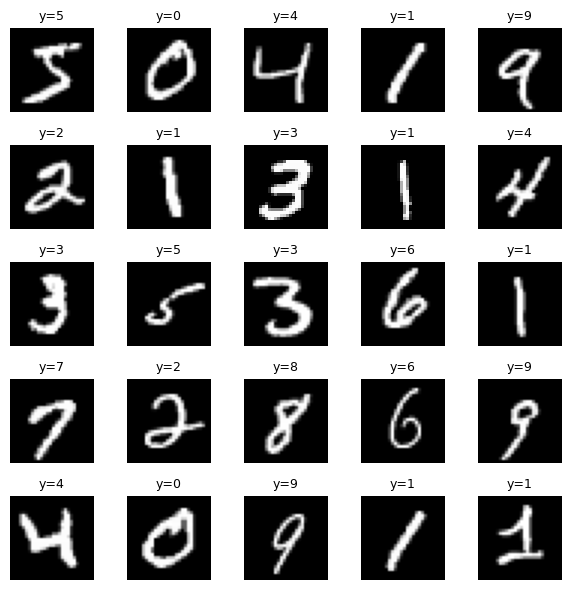

In [11]:
MEAN, STD = 0.1307, 0.3081

fig, axes = plt.subplots(5, 5, figsize=(6,6))
axes = axes.flatten()
for i in range(25):
    img, label = train_full[i]            # (1,28,28) normalized tensor, int label
    img = (img * STD + MEAN).squeeze(0)   # de-normalize & drop channel
    axes[i].imshow(img.numpy(), cmap="gray")
    axes[i].set_title(f"y={label}", fontsize=9)
    axes[i].axis("off")
plt.tight_layout()
plt.show()


### CNN Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes: int = 10,
                 kernel_size=3, num_convs=2, agg='flatten'):
        super().__init__()
        assert agg in ('flatten', 'gap')
        self.agg = agg

        channels = [32, 64, 128][:max(1, min(num_convs, 3))]
        blocks = []
        c_prev = in_channels
        pad = kernel_size // 2
        for c in channels:
            blocks += [
                nn.Conv2d(c_prev, c, kernel_size=kernel_size, padding=pad, bias=False),
                nn.BatchNorm2d(c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            ]
            c_prev = c
        self.features = nn.Sequential(*blocks)

        if agg == 'gap':
            self.head = nn.Linear(c_prev, num_classes)
        else:
            with torch.no_grad():
                dummy = torch.zeros(1, 1, 28, 28)
                f = self.features(dummy)
                flat_dim = f.numel()
            self.head = nn.Linear(flat_dim, num_classes)

    def forward(self, x):
        x = self.features(x)
        if self.agg == 'gap':
            x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        else:
            x = torch.flatten(x, 1)
        return self.head(x)
    
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_correct, total = 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        total_correct += (logits.argmax(1) == yb).sum().item()
        total += yb.size(0)
    return total_correct / total

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    running_acc  = 0.0
    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * yb.size(0)
        running_acc  += (logits.argmax(1) == yb).sum().item()
    n = len(loader.dataset)
    return running_loss / n, running_acc / n

def fit(model, train_loader, val_loader, device, lr=1e-3, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = 0.0
    best_state = None
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device)
        val_acc = evaluate(model, val_loader, device)
        if val_acc > best_val:
            best_val = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} | train acc {tr_acc:.4f} | val acc {val_acc:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val

### Model Training

In [20]:
results = []
best = {"val": -1}

for k, n, lr in itertools.product([3,5,7], [2,3], [1e-3, 1e-2]):
    m = CNN(kernel_size=k, num_convs=n, agg='gap')
    m, v = fit(m, train_loader, val_loader, device, lr=lr, epochs=3)  # short runs
    t = evaluate(m, test_loader, device)
    results.append({"kernel": k, "layers": n, "lr": lr, "val_acc": v, "test_acc": t})
    if v > best["val"]:
        best = {"k": k, "n": n, "lr": lr, "val": v, "test": t, "state": {k2:v2.cpu() for k2,v2 in m.state_dict().items()}}

pd.DataFrame(results).sort_values("val_acc", ascending=False)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 1.3970 | train acc 0.6555 | val acc 0.8145


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.6739 | train acc 0.8682 | val acc 0.8755


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.4294 | train acc 0.9104 | val acc 0.9193


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.6439 | train acc 0.8127 | val acc 0.8029


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.1821 | train acc 0.9514 | val acc 0.8935


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.1336 | train acc 0.9622 | val acc 0.9567


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.3069 | train acc 0.9430 | val acc 0.9588


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.0598 | train acc 0.9857 | val acc 0.9726


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.0400 | train acc 0.9897 | val acc 0.9837


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.1995 | train acc 0.9422 | val acc 0.9759


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.0473 | train acc 0.9852 | val acc 0.9794


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.0341 | train acc 0.9893 | val acc 0.9870


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.9258 | train acc 0.8182 | val acc 0.8646


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.2599 | train acc 0.9494 | val acc 0.9250


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.1624 | train acc 0.9631 | val acc 0.9455


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.3814 | train acc 0.8948 | val acc 0.9296


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.0855 | train acc 0.9763 | val acc 0.9669


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.0579 | train acc 0.9831 | val acc 0.9790


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.1709 | train acc 0.9637 | val acc 0.9775


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.0370 | train acc 0.9903 | val acc 0.9121


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.0272 | train acc 0.9923 | val acc 0.9871


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.1599 | train acc 0.9528 | val acc 0.9814


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.0419 | train acc 0.9865 | val acc 0.9866


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.0280 | train acc 0.9911 | val acc 0.9808


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.6223 | train acc 0.8816 | val acc 0.8878


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.1553 | train acc 0.9663 | val acc 0.9255


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.1030 | train acc 0.9756 | val acc 0.9506


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.3341 | train acc 0.9037 | val acc 0.9656


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.0668 | train acc 0.9802 | val acc 0.9838


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.0488 | train acc 0.9855 | val acc 0.9867


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.1433 | train acc 0.9669 | val acc 0.9800


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.0355 | train acc 0.9896 | val acc 0.9866


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.0245 | train acc 0.9930 | val acc 0.9815


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 01 | train loss 0.1882 | train acc 0.9408 | val acc 0.9826


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 02 | train loss 0.0425 | train acc 0.9865 | val acc 0.9868


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03 | train loss 0.0285 | train acc 0.9913 | val acc 0.9865


,kernel,layers,lr,val_acc,test_acc
6,5,3,0.001,0.9871,0.9894
3,3,3,0.010,0.9870,0.9886
11,7,3,0.010,0.9868,0.9898
9,7,2,0.010,0.9867,0.9848
7,5,3,0.010,0.9866,0.9885
10,7,3,0.001,0.9866,0.9891
2,3,3,0.001,0.9837,0.9837
5,5,2,0.010,0.9790,0.9791
1,3,2,0.010,0.9567,0.9592
8,7,2,0.001,0.9506,0.9562


### Confusion Matrix

Test accuracy: 0.9894


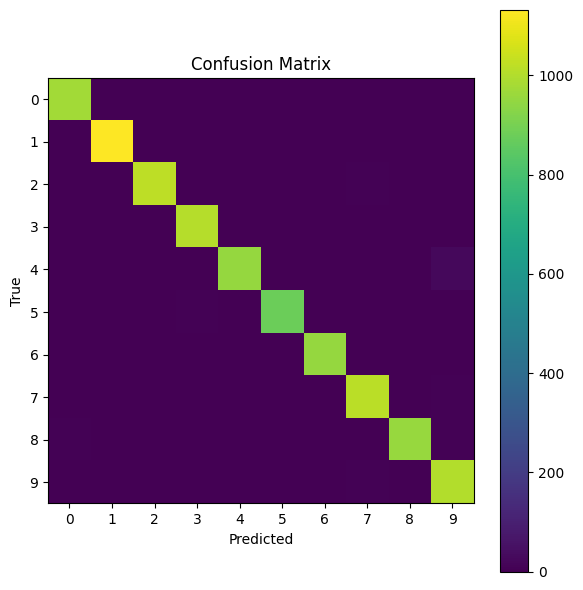

In [21]:
best_model = CNN(kernel_size=best["k"], num_convs=best["n"], agg='gap')
best_model.load_state_dict(best["state"])
best_model.to(device)

# compute confusion matrix on test
all_preds, all_labels = [], []
best_model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = best_model(xb).argmax(1).cpu()
        all_preds.append(preds)
        all_labels.append(yb)
all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

cm = confusion_matrix(all_labels, all_preds)
print("Test accuracy:", (cm.trace()/cm.sum()))

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar(); plt.xticks(np.arange(10)); plt.yticks(np.arange(10))
plt.tight_layout(); plt.show()